In [44]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd

import tarfile
import io
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from tqdm import tqdm
import random
from sklearn.metrics import f1_score
import wandb
import cv2

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
torch.set_printoptions(threshold=torch.inf)

In [47]:
class CONFIG:
    SEED = 42
    
    CLASSIFIER_LR = 3e-4
    
    EPOCH = 200
    BATCH_SIZE = 8
    TARGET_SIZE = (128, 128)  

    SR = 44100
    N_MEL = 128
    DURATION = 0.1
    #NUM_AUGMENTATIONS = 10
    N_FFT = 2048
    HOP_LENGTH = 32

    NOISE_DIR = 'background_noises'
    DATA_DIR = 'data'

In [48]:
wandb.init(project="audio_fall")

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_f1,▄▄▆▇▁▂█▇▆▇▇▇▆▇▇▇▆
val_loss,▅▄▂▁▇█▁▁▃▂▁▄▂▂▂▃▄
epoch,17
train_loss,0.00182
val_f1,0.99939
val_loss,0.00275


In [49]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [51]:

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.duration = 5.0

        print(self.classes)

        self.audio_paths = []
        self.labels = []

        for label, cls in enumerate(self.classes):
            cls_path = os.path.join(root_dir, cls)
            audio_files = os.listdir(cls_path)
            for audio_file in tqdm(audio_files):
                audio_path = os.path.join(cls_path, audio_file)
                self.audio_paths.append(audio_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        

        y, sr = librosa.load(audio_path, sr=CONFIG.SR)

        duration = librosa.get_duration(y=y, sr=sr)
        num_samples_to_keep = int(self.duration * sr)
    
        if duration > self.duration:
            y = y[:num_samples_to_keep]
            duration = self.duration

        else:
        # 오디오가 5초보다 짧으면 패딩 추가
            num_samples_to_pad = num_samples_to_keep - len(y)
            y = np.pad(y, (0, num_samples_to_pad), mode='constant')
        

        S = librosa.feature.mfcc(
            y=y, 
            sr=CONFIG.SR,
            n_mfcc=40
        )

        S = cv2.resize(S, (224, 224))
        

        S = torch.FloatTensor(S)
        S = S.unsqueeze(0)

        

        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)

        return S, label


In [52]:
train_dataset = CustomDataset('./audio/train')



['fall', 'good']


100%|██████████| 6215/6215 [00:00<00:00, 1084523.19it/s]


In [53]:
train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)

In [54]:

# Dataset 및 타겟 정의
targets = train_dataset.labels

# StratifiedShuffleSplit 사용
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=CONFIG.SEED)

# StratifiedShuffleSplit은 인덱스를 반환하므로 이를 활용해 train/val 인덱스 분리
for train_idx, val_idx in stratified_split.split(train_dataset, targets):
    train_dataset_split = Subset(train_dataset, train_idx)
    val_dataset_split = Subset(train_dataset, val_idx)

# DataLoader 설정
train_loader = DataLoader(train_dataset_split, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset_split, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=0)


In [55]:
print(f'Train Loader Data Count: {len(train_loader.dataset)}')
print(f'Validation Loader Data Count: {len(val_loader.dataset)}')


Train Loader Data Count: 19629
Validation Loader Data Count: 4908


In [56]:
test_dataset = CustomDataset('./audio/test')

test_loader = DataLoader(test_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

['fall', 'good']


100%|██████████| 2865/2865 [00:00<00:00, 969243.50it/s]


In [57]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)

        # 첫 번째 Conv2D 레이어의 가중치와 bias를 얻기
        first_conv_layer = self.backbone.features[0][0]

        # 새로운 Conv2D 레이어 생성 (in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        new_first_conv_layer = torch.nn.Conv2d(
            in_channels=1, 
            out_channels=first_conv_layer.out_channels, 
            kernel_size=first_conv_layer.kernel_size, 
            stride=first_conv_layer.stride, 
            padding=first_conv_layer.padding, 
            bias=first_conv_layer.bias is not None
        )

        # 기존 Conv2D 레이어의 가중치 평균을 새로운 레이어에 복사 (채널 수를 맞추기 위해)
        with torch.no_grad():
            new_first_conv_layer.weight = torch.nn.Parameter(
                first_conv_layer.weight.mean(dim=1, keepdim=True)
            )

        # EfficientNet 모델의 첫 번째 Conv2D 레이어를 새로운 레이어로 교체
        self.backbone.features[0][0] = new_first_conv_layer
        num_features = self.backbone.classifier[1].in_features  # 기존 출력층의 입력 feature 수
        self.backbone.classifier[1] = torch.nn.Linear(num_features, 2)  # 2개의 클래스로 변경

        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [58]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0, mode='min', verbose=True):
        """
        patience (int): loss or score가 개선된 후 기다리는 기간. default: 3
        delta  (float): 개선시 인정되는 최소 변화 수치. default: 0.0
        mode     (str): 개선시 최소/최대값 기준 선정('min' or 'max'). default: 'min'.
        verbose (bool): 메시지 출력. default: True
        """
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        
        self.best_score = np.Inf if mode == 'min' else 0
        self.mode = mode
        self.delta = delta
        

    def __call__(self, score):

        if self.best_score is None:
            self.best_score = score
            self.counter = 0
        elif self.mode == 'min':
            if score < (self.best_score - self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
        elif self.mode == 'max':
            if score > (self.best_score + self.delta):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f'[EarlyStopping] (Update) Best Score: {self.best_score:.5f}')
            else:
                self.counter += 1
                if self.verbose:
                    print(f'[EarlyStopping] (Patience) {self.counter}/{self.patience}, ' \
                          f'Best: {self.best_score:.5f}' \
                          f', Current: {score:.5f}, Delta: {np.abs(self.best_score - score):.5f}')
                
            
        if self.counter >= self.patience:
            if self.verbose:
                print(f'[EarlyStop Triggered] Best Score: {self.best_score:.5f}')
            # Early Stop
            self.early_stop = True
        else:
            # Continue
            self.early_stop = False

In [59]:
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    
    for epoch in range(1, CONFIG.EPOCH):
        model.train()
        train_loss = []
        for videos, labels in tqdm(iter(train_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(videos)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        wandb.log({
            'epoch': epoch,
            'train_loss': _train_loss,
            'val_loss': _val_loss,
            'val_f1': _val_score
        })

        es(_val_loss)

        if es.early_stop:
            print("Early Stopping")
            break
    torch.save(model.state_dict(),  'audio_eff_sq.pt')
        

            

In [60]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for videos, labels in tqdm(iter(val_loader)):
            videos = videos.to(device)
            labels = labels.to(device)
            
            logit = model(videos)
            
            loss = criterion(logit, labels)
            
            val_loss.append(loss.item())
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='weighted')
    return _val_loss, _val_score

In [61]:
classifer_model = CustomClassifier()
classifier_optimizer = torch.optim.AdamW(params=classifer_model.parameters(), lr=CONFIG.CLASSIFIER_LR)
classifier_scheduler = torch.optim.lr_scheduler.LambdaLR(classifier_optimizer, lr_lambda = lambda epoch: 1.0 ** CONFIG.EPOCH)
criterion = nn.CrossEntropyLoss()

In [62]:
es = EarlyStopping(patience=10, delta=0.0, mode='min', verbose=True)


In [63]:
train(classifer_model, classifier_optimizer, train_loader, val_loader, device)

100%|██████████| 614/614 [12:45<00:00,  1.25s/it]


Epoch [1], Train Loss : [0.02530] Val Loss : [0.00146] Val F1 : [0.99939]
[EarlyStopping] (Update) Best Score: 0.00146


100%|██████████| 614/614 [11:09<00:00,  1.09s/it]


Epoch [2], Train Loss : [0.00846] Val Loss : [0.00602] Val F1 : [0.99898]
[EarlyStopping] (Patience) 1/10, Best: 0.00146, Current: 0.00602, Delta: 0.00456


100%|██████████| 614/614 [09:59<00:00,  1.02it/s]


Epoch [3], Train Loss : [0.00610] Val Loss : [0.00112] Val F1 : [0.99959]
[EarlyStopping] (Update) Best Score: 0.00112


100%|██████████| 614/614 [10:48<00:00,  1.06s/it]


Epoch [4], Train Loss : [0.00695] Val Loss : [0.00079] Val F1 : [0.99959]
[EarlyStopping] (Update) Best Score: 0.00079


100%|██████████| 614/614 [11:21<00:00,  1.11s/it]


Epoch [5], Train Loss : [0.00271] Val Loss : [0.00164] Val F1 : [0.99959]
[EarlyStopping] (Patience) 1/10, Best: 0.00079, Current: 0.00164, Delta: 0.00085


100%|██████████| 614/614 [10:54<00:00,  1.07s/it]


Epoch [6], Train Loss : [0.00368] Val Loss : [0.00019] Val F1 : [0.99980]
[EarlyStopping] (Update) Best Score: 0.00019


100%|██████████| 614/614 [10:47<00:00,  1.05s/it]


Epoch [7], Train Loss : [0.00290] Val Loss : [0.00062] Val F1 : [0.99980]
[EarlyStopping] (Patience) 1/10, Best: 0.00019, Current: 0.00062, Delta: 0.00043


100%|██████████| 614/614 [10:17<00:00,  1.01s/it]


Epoch [8], Train Loss : [0.00321] Val Loss : [0.00139] Val F1 : [0.99959]
[EarlyStopping] (Patience) 2/10, Best: 0.00019, Current: 0.00139, Delta: 0.00119


100%|██████████| 614/614 [10:19<00:00,  1.01s/it]


Epoch [9], Train Loss : [0.00185] Val Loss : [0.02663] Val F1 : [0.99756]
[EarlyStopping] (Patience) 3/10, Best: 0.00019, Current: 0.02663, Delta: 0.02644


100%|██████████| 614/614 [10:15<00:00,  1.00s/it]


Epoch [10], Train Loss : [0.00148] Val Loss : [0.00061] Val F1 : [0.99980]
[EarlyStopping] (Patience) 4/10, Best: 0.00019, Current: 0.00061, Delta: 0.00042


100%|██████████| 614/614 [10:18<00:00,  1.01s/it]


Epoch [11], Train Loss : [0.00149] Val Loss : [0.00013] Val F1 : [1.00000]
[EarlyStopping] (Update) Best Score: 0.00013


100%|██████████| 614/614 [10:17<00:00,  1.01s/it]


Epoch [12], Train Loss : [0.00007] Val Loss : [0.00000] Val F1 : [1.00000]
[EarlyStopping] (Update) Best Score: 0.00000


100%|██████████| 614/614 [10:15<00:00,  1.00s/it]


Epoch [13], Train Loss : [0.00000] Val Loss : [0.00001] Val F1 : [1.00000]
[EarlyStopping] (Patience) 1/10, Best: 0.00000, Current: 0.00001, Delta: 0.00001


100%|██████████| 614/614 [10:17<00:00,  1.01s/it]


Epoch [14], Train Loss : [0.00385] Val Loss : [0.00672] Val F1 : [0.99898]
[EarlyStopping] (Patience) 2/10, Best: 0.00000, Current: 0.00672, Delta: 0.00672


100%|██████████| 614/614 [10:17<00:00,  1.01s/it]


Epoch [15], Train Loss : [0.00140] Val Loss : [0.00013] Val F1 : [1.00000]
[EarlyStopping] (Patience) 3/10, Best: 0.00000, Current: 0.00013, Delta: 0.00013


100%|██████████| 614/614 [10:29<00:00,  1.03s/it]


Epoch [16], Train Loss : [0.00069] Val Loss : [0.00082] Val F1 : [0.99980]
[EarlyStopping] (Patience) 4/10, Best: 0.00000, Current: 0.00082, Delta: 0.00082


100%|██████████| 614/614 [09:08<00:00,  1.12it/s]


Epoch [17], Train Loss : [0.00001] Val Loss : [0.00011] Val F1 : [1.00000]
[EarlyStopping] (Patience) 5/10, Best: 0.00000, Current: 0.00011, Delta: 0.00011


100%|██████████| 614/614 [09:08<00:00,  1.12it/s]


Epoch [18], Train Loss : [0.00000] Val Loss : [0.00039] Val F1 : [0.99980]
[EarlyStopping] (Patience) 6/10, Best: 0.00000, Current: 0.00039, Delta: 0.00039


100%|██████████| 614/614 [09:08<00:00,  1.12it/s]


Epoch [19], Train Loss : [0.00000] Val Loss : [0.00017] Val F1 : [0.99980]
[EarlyStopping] (Patience) 7/10, Best: 0.00000, Current: 0.00017, Delta: 0.00017


100%|██████████| 614/614 [09:24<00:00,  1.09it/s]


Epoch [20], Train Loss : [0.00253] Val Loss : [0.00126] Val F1 : [0.99959]
[EarlyStopping] (Patience) 8/10, Best: 0.00000, Current: 0.00126, Delta: 0.00126


100%|██████████| 614/614 [09:15<00:00,  1.11it/s]


Epoch [21], Train Loss : [0.00112] Val Loss : [0.00233] Val F1 : [0.99939]
[EarlyStopping] (Patience) 9/10, Best: 0.00000, Current: 0.00233, Delta: 0.00233


100%|██████████| 614/614 [09:17<00:00,  1.10it/s]

Epoch [22], Train Loss : [0.00057] Val Loss : [0.00058] Val F1 : [0.99980]
[EarlyStopping] (Patience) 10/10, Best: 0.00000, Current: 0.00058, Delta: 0.00058
[EarlyStop Triggered] Best Score: 0.00000
Early Stopping


In [64]:
ckpt_classifier_model = CustomClassifier()


In [65]:
ckpt_classifier_model.load_state_dict(torch.load('./audio_eff_sq.pt'))
ckpt_classifier_model.eval()

CustomClassifier(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [66]:
def test(best_classifier_model, test_loader, device):

    best_classifier_model.to(device)
    best_classifier_model.eval()

    preds, labels = [], []

    with torch.no_grad():
        for S, label in tqdm(iter(test_loader)):

            S = S.float().to(device)
            label = label.to(device)

            classifier_output = best_classifier_model(S)



            preds += classifier_output.argmax(1).detach().cpu().numpy().tolist()
            labels += label.detach().cpu().numpy().tolist()



    print(preds[:10])
    print(labels[:10])
    f1 = f1_score(labels, preds, average='weighted')
    print(f'Test F1 Score: {f1:.4f}')


In [67]:
test(ckpt_classifier_model, test_loader, device)

100%|██████████| 486/486 [12:52<00:00,  1.59s/it]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test F1 Score: 0.9982


In [68]:
model_duration = 5.0
y, sr = librosa.load('./audio/test/fall/10.낙상_317473_label.wav', sr=44100)
duration = librosa.get_duration(y=y, sr=sr)
        
if duration > model_duration:
    num_samples_to_keep = int(model_duration * sr)
    y = y[:num_samples_to_keep]
    duration = model_duration
    
S = librosa.feature.mfcc(
    y=y, 
    sr=sr,
    n_mfcc=40
)

S = cv2.resize(S, (224, 224))

    

S = torch.FloatTensor(S)
S = S.unsqueeze(0)
S = S.unsqueeze(0)
print(S.shape)
ckpt_classifier_model.to(device)

with torch.no_grad():
    S = S.to(device)
    logit = ckpt_classifier_model(S)
    pred = logit.argmax(1).detach().cpu().numpy()

print(f"pred = {pred}")

torch.Size([1, 1, 224, 224])
pred = [0]


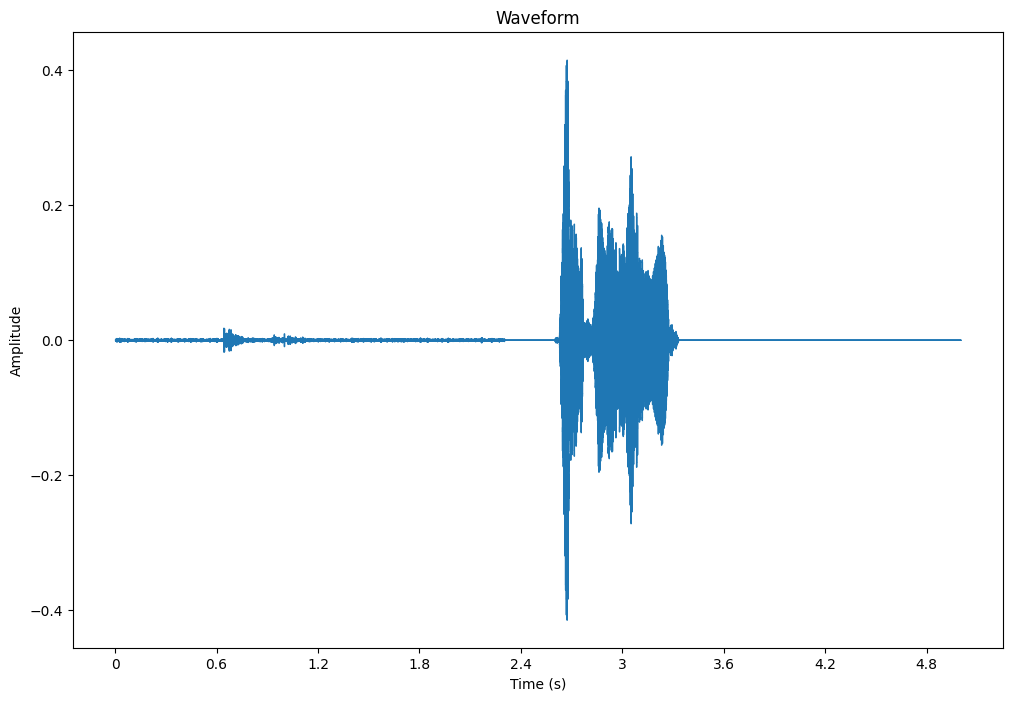

In [69]:
from matplotlib import pyplot as plt
model_duration = 5.0
y, sr = librosa.load('./audio/test/fall/10.낙상_317473_label.wav', sr=44100)
duration = librosa.get_duration(y=y, sr=sr)
num_samples_to_keep = int(model_duration * sr)

if duration > model_duration:
    y = y[:num_samples_to_keep]
    duration = model_duration
else:
    # 오디오가 5초보다 짧으면 패딩 추가
    num_samples_to_pad = num_samples_to_keep - len(y)
    y = np.pad(y, (0, num_samples_to_pad), mode='constant')
    
# 파형 시각화
plt.figure(figsize=(12, 8))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



In [70]:
from matplotlib import pyplot as plt
model_duration = 5.0
y, sr = librosa.load('./audio/test/fall/10.낙상_317473_label.wav', sr=44100)
duration = librosa.get_duration(y=y, sr=sr)
num_samples_to_keep = int(model_duration * sr)

if duration > model_duration:
    y = y[:num_samples_to_keep]
    duration = model_duration
else:
    # 오디오가 5초보다 짧으면 패딩 추가
    num_samples_to_pad = num_samples_to_keep - len(y)
    y = np.pad(y, (0, num_samples_to_pad), mode='constant')
    
# 파형 시각화
S = librosa.feature.mfcc(
    y=y, 
    sr=sr,
    n_mfcc=40
)

S = cv2.resize(S, (224, 224))



plt.imsave('haha.png', S, cmap="magma")



In [71]:
os.listdir('./audio/test')

['fall', 'good']